In [75]:
from typing import Type, Optional, Union, Tuple

import itertools
import multiprocessing

import numpy as np
import pandas as pd
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK
from skopt import gp_minimize

import matplotlib.pyplot as plt 
plt.rcParams['figure.facecolor'] = "white"

from reservoir import reservoir as res
from data import data
from error import error

For any $t_i$, its corresponding RMSE over the next unit Lyapunov time is given by
$$
    \varepsilon_i = \frac{1}{\sigma} \left( \Delta t \lambda \sum_{t=t_i}^{t_i + \frac{1}{\lambda}} |\mathbf{u}(t) - W_{\text{out}} \tilde{\mathbf{r}}(t)|^2 \right)^{0.5} 
$$
where $\sigma$ is the standard deviation of space norms over time

In [76]:
# define constants 
DEL_T = 0.01        # time step size
LAMBDA = 0.9056     # lorenz lyapunov exponent
STEPS = 30000       # total steps
WASHOUT = 10000     # washout 
n = STEPS - WASHOUT # remaining number of time steps kept
SEED = 42
state = np.random.RandomState(SEED)

In [77]:
# reservoir parameters
hyperparams = {
    'GAMMA': 7.7,
    'SIGMA': 0.81,
    'RHO_IN': 0.37,
    'K': 3,
    'RHO_R': 0.41
}

# hyperparameter ranges
GAMMA_RANGE = np.linspace(7, 11, 10)
SIGMA_RANGE = np.linspace(0.1, 1.0, 10)
RHO_IN_RANGE = np.linspace(0.3, 1.5, 10)
K_RANGE = range(1, 6)
RHO_R_RANGE = np.linspace(0.3, 1.5, 10)

# number of reservoir nodes
N = 100
# dimension of input signal
d = 3
# Tikohonov regularisation constant
ALPHA = 0.001

In [78]:
lorenz = data.generate_lorenz_63(
        initial_state=state.choice(np.linspace(-5, 5), 3),
        del_t=DEL_T,
        steps=STEPS,
        washout=WASHOUT
    )
training_data = lorenz[: lorenz.shape[0] // 2]
test_data = lorenz[lorenz.shape[0] // 2:]

In [79]:
# construct reservoir internals
W_in = res.generate_W_in(hyperparams=hyperparams, shape=(N, d), state=state)
W_r = res.generate_W_r(hyperparams=hyperparams, shape=(N, N), state=state)

unmodified_training_res = res.generate_training_reservoir(
    data=training_data,
    hyperparams=hyperparams,
    W_r=W_r,
    W_in=W_in,
    delta_t=DEL_T,
    adjust_for_symmetry=False
)

# form training reservoir
training_res = res.generate_training_reservoir(
    data=training_data,
    hyperparams=hyperparams,
    W_r=W_r,
    W_in=W_in,
    delta_t=DEL_T,
    adjust_for_symmetry=True
)

# train W_out
W_out = res.generate_W_out(
    data=training_data,
    res=training_res,
    alpha=ALPHA
)

In [80]:
# construct forecast reservoir
forecast_res = res.generate_forecast_reservoir(
    # r_0 = np.dot(W_in, test_data[0]),
    r_0 = unmodified_training_res[-1],
    data=test_data,
    hyperparams=hyperparams,
    W_r=W_r,
    W_in=W_in,
    W_out=W_out,
    delta_t=DEL_T,
    adjust_for_symmetry=True
)

# make forecasts
preds = res.readout_network(res=forecast_res, W_out=W_out)

[0.71761732 0.81344024 0.51645587]
2.0573486863386012


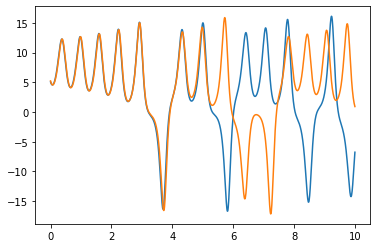

In [81]:
end = data.lyapunov_to_steps(10, LAMBDA, DEL_T)
x_range = LAMBDA * DEL_T * np.array(range(end))
plt.plot(x_range, test_data[:end, 0])
plt.plot(x_range, preds[:end, 0])
print(error.RMSE(test_data[:end], preds[:end]))
print(error.griffith_epsilon_1(test_data[:end], preds[:end], DEL_T, LAMBDA, t_1=0))

In [82]:
n = test_data.shape[0]
t_i_range = np.arange(0, n, 200)

In [83]:
errors = []
for t_i in t_i_range:
    errors.append(error.griffith_epsilon_1(
        u=test_data,
        u_hat=preds,
        delta_t=DEL_T,
        LAMBDA=LAMBDA,
        t_1=t_i
    ) ** 2)
eps = np.sqrt(np.sum(errors) / 50)

In [84]:
eps

0.4563919937651865

In [85]:
def objective(hyperparams: list) -> float:
    # parse hyperparams
    hyperparams = {
        'GAMMA': hyperparams[0],
        'SIGMA': hyperparams[1],
        'RHO_IN': hyperparams[2],
        'K': hyperparams[3],
        'RHO_R': hyperparams[4]
    }

    # construct reservoir internals
    W_in = res.generate_W_in(hyperparams=hyperparams, shape=(N, d), state=state)
    W_r = res.generate_W_r(hyperparams=hyperparams, shape=(N, N), state=state)

    unmodified_training_res = res.generate_training_reservoir(
        data=training_data,
        hyperparams=hyperparams,
        W_r=W_r,
        W_in=W_in,
        delta_t=DEL_T,
        adjust_for_symmetry=False
    )

    # form training reservoir
    training_res = res.generate_training_reservoir(
        data=training_data,
        hyperparams=hyperparams,
        W_r=W_r,
        W_in=W_in,
        delta_t=DEL_T,
        adjust_for_symmetry=True
    )

    # train W_out
    W_out = res.generate_W_out(
        data=training_data,
        res=training_res,
        alpha=ALPHA
    )
    
    # construct forecast reservoir
    forecast_res = res.generate_forecast_reservoir(
        # r_0 = np.dot(W_in, test_data[0]),
        r_0 = unmodified_training_res[-1],
        data=test_data,
        hyperparams=hyperparams,
        W_r=W_r,
        W_in=W_in,
        W_out=W_out,
        delta_t=DEL_T,
        adjust_for_symmetry=True
    )

    # make forecasts
    preds = res.readout_network(res=forecast_res, W_out=W_out)

    n = test_data.shape[0]
    t_i_range = np.arange(0, n, n // 50)

    errors = []
    for t_i in t_i_range:
        errors.append(error.griffith_epsilon_1(
            u=test_data,
            u_hat=preds,
            delta_t=DEL_T,
            LAMBDA=LAMBDA,
            t_1=t_i
        ) ** 2)

    return np.sqrt(np.sum(errors) / 50)

In [86]:
def find_start_and_end(range):
    return range[0], range[-1]

def generate_search_space(gamma_range=GAMMA_RANGE, sigma_range=SIGMA_RANGE, 
                          rho_in_range=RHO_IN_RANGE, k_range=K_RANGE, 
                          rho_r_range=RHO_R_RANGE) -> list:
    gamma_start, gamma_end = find_start_and_end(gamma_range)
    sigma_start, sigma_end = find_start_and_end(sigma_range)
    rho_in_start, rho_in_end = find_start_and_end(rho_in_range)
    k_start, k_end = find_start_and_end(k_range)
    rho_r_start, rho_r_end = find_start_and_end(rho_r_range)

    return [
        hp.uniform('gamma', gamma_start, gamma_end),
        hp.uniform('sigma', sigma_start, sigma_end),
        hp.uniform('rho_in', rho_in_start, rho_in_end),
        hp.choice('k', options=list(range(k_start, k_end + 1))),
        hp.uniform('rho_r', rho_r_start, rho_r_end),
    ]

# hyperparameter ranges
GAMMA_RANGE = np.linspace(7, 11, 10)
SIGMA_RANGE = np.linspace(0.1, 1.0, 10)
RHO_IN_RANGE = np.linspace(0.3, 1.5, 10)
K_RANGE = range(1, 6)
RHO_R_RANGE = np.linspace(0.3, 1.5, 10)


In [87]:
trials = Trials()
best = fmin(
    fn=objective,
    space=generate_search_space(),
    algo=tpe.suggest,
    max_evals=20,
    trials=trials
)

  5%|▌         | 1/20 [00:08<02:41,  8.48s/trial, best loss: 0.3864370572223825]


KeyboardInterrupt: 

In [ ]:
hyperparams = {
    'GAMMA': best['gamma'],
    'SIGMA': best['sigma'],
    'RHO_IN': best['rho_in'],
    'K': best['k'],
    'RHO_R': best['rho_r']
}

In [ ]:
hyperparams

{'GAMMA': 7.260449232609288,
 'SIGMA': 0.37396108001474015,
 'RHO_IN': 0.8718492764367041,
 'K': 2,
 'RHO_R': 1.0056499651091906}

In [ ]:
# construct reservoir internals
W_in = res.generate_W_in(hyperparams=hyperparams, shape=(N, d), state=state)
W_r = res.generate_W_r(hyperparams=hyperparams, shape=(N, N), state=state)

unmodified_training_res = res.generate_training_reservoir(
    data=training_data,
    hyperparams=hyperparams,
    W_r=W_r,
    W_in=W_in,
    delta_t=DEL_T,
    adjust_for_symmetry=False
)

# form training reservoir
training_res = res.generate_training_reservoir(
    data=training_data,
    hyperparams=hyperparams,
    W_r=W_r,
    W_in=W_in,
    delta_t=DEL_T,
    adjust_for_symmetry=True
)

# train W_out
W_out = res.generate_W_out(
    data=training_data,
    res=training_res,
    alpha=ALPHA
)

# construct forecast reservoir
forecast_res = res.generate_forecast_reservoir(
    # r_0 = np.dot(W_in, test_data[0]),
    r_0 = unmodified_training_res[-1],
    data=test_data,
    hyperparams=hyperparams,
    W_r=W_r,
    W_in=W_in,
    W_out=W_out,
    delta_t=DEL_T,
    adjust_for_symmetry=True
)

# make forecasts
preds = res.readout_network(res=forecast_res, W_out=W_out)

[0.70282693 0.77896571 0.68218707]
0.22832289064822298


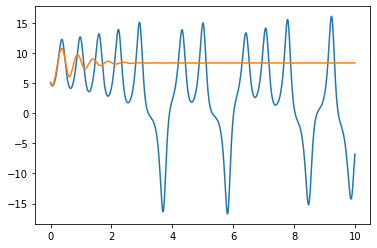

In [ ]:
# evaluate
end = data.lyapunov_to_steps(10, LAMBDA, DEL_T)
# end = test_data.shape[0]
x_range = LAMBDA * DEL_T * np.array(range(end))
plt.plot(x_range, test_data[:end, 0])
plt.plot(x_range, preds[:end, 0])
print(error.RMSE(test_data[:end], preds[:end]))
print(error.griffith_epsilon_1(test_data[:end], preds[:end], DEL_T, LAMBDA, t_1=0))

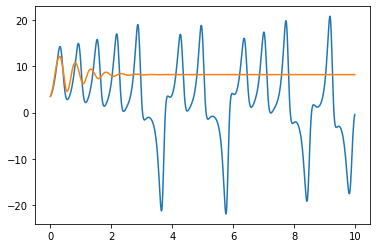

In [ ]:
plt.plot(x_range, test_data[:end, 1])
plt.plot(x_range, preds[:end, 1])

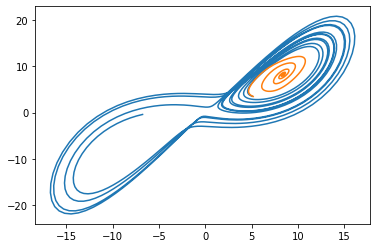

In [ ]:
plt.plot(test_data[:end, 0], test_data[:end, 1])
plt.plot(preds[:end, 0], preds[:end, 1])

In [ ]:
n = test_data.shape[0]
t_i_range = np.arange(0, n, n // 50)
errors = []
for t_i in t_i_range:
    errors.append(error.griffith_epsilon_1(
        u=test_data,
        u_hat=preds,
        delta_t=DEL_T,
        LAMBDA=LAMBDA,
        t_1=t_i
    ) ** 2)
eps = np.sqrt(np.sum(errors) / 50)
eps

0.3985787716582352